In [1]:
import numpy as np
import os
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import imageio
import cv2

from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from kmapper.cover import Cover
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx
from community import best_partition # this is not part of networkx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio
import plotly
import plotly.graph_objs as go

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

import math

def round_up_to_even(f):
    return int(math.ceil(f / 2.) * 2)

In [45]:
Mwidths = 60 #width of the nucleus img
Mheights = 60 #height in pixel of the nucleus image

n_neighbors = 10 # in the UMAP algorithm

num_rnd_Lcell = 200 # numb of labeled cells per type (max 200)
num_rnd_Limg = 30 # numb of augmentation per labeled cell (max 720)

num_rnd_Ncell = 600 # numb of new cells per type (max 200)
num_rnd_Nimg = 30 # numb of augmentation per new cell (max 720)

In [54]:
'''Loading the training data as a pandas dataframe'''
directories = ['/home/garner1/Work/dataset/cellImages/training_augmented/Cancer',
               '/home/garner1/Work/dataset/cellImages/training_augmented/Immuno',
              '/home/garner1/Work/dataset/cellImages/training_augmented/Other']

'''Box each nucleus'''
cell_labels = []
target_id = 0
widths = []
heights = []
target = []
for directory in directories:
    target_id += 1
    cell_id = 0
    cellList = random.sample(os.listdir(directory), k=num_rnd_Lcell)
    if directory == directories[0]: cellList_cancer = list(cellList)
    if directory == directories[1]: cellList_immuno = list(cellList)
    if directory == directories[2]: cellList_other = list(cellList)
    for cell in cellList:
        path = os.path.join(directory, cell)
        cell_id += 1
        imgList = random.sample(os.listdir(path), k=num_rnd_Limg) #sample images
        if directory == directories[0]: imgList_cancer = list(imgList)
        if directory == directories[1]: imgList_immuno = list(imgList)
        if directory == directories[2]: imgList_other = list(imgList)
        for img in imgList:
            filename = os.path.join(path, img)
            img = imageio.imread(filename)
            rmin, rmax, cmin, cmax = bbox(img)
            width = rmax-rmin
            height = cmax-cmin
            widths.append(width)
            heights.append(height)
            target.append(target_id)    
            cell_labels.append(cell_id)
        
            
'''Resizing images to small boxes'''
images = []
for directory in directories:
    if directory == directories[0]: cellList = list(cellList_cancer)
    if directory == directories[1]: cellList = list(cellList_immuno)
    if directory == directories[2]: cellList = list(cellList_other)
    for cell in cellList:
        path = os.path.join(directory, cell)
        if directory == directories[0]: imgList = list(imgList_cancer)
        if directory == directories[1]: imgList = list(imgList_immuno)
        if directory == directories[2]: imgList = list(imgList_other)
        for img in imgList:
            filename = os.path.join(path, img)
            img = imageio.imread(filename)
            rmin, rmax, cmin, cmax = bbox(img)
            delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            newimg = np.pad(img[rmin:rmax,cmin:cmax],((left,right),(top,bottom)),'constant', constant_values=(0))
            images.append(newimg)
            
X_labeled = np.zeros((len(images),Mwidths*Mheights))
for ind in range(len(images)):
    X_labeled[ind,:] = images[ind].flatten() # from 2D arrays to 1D arrays

print(X_labeled.shape)

'''_2_'''
target = []
directory = '/home/garner1/Work/dataset/cellImages/image52/augmented'
cell_labels = []
images = []
cell_id = 0
count = 0
total = 0
imgLists = []
cellList = random.sample(os.listdir(directory), k=num_rnd_Ncell)
for cell in cellList:
    cell_id += 1
    path = os.path.join(directory, cell)
    imgList = random.sample(os.listdir(path), k=num_rnd_Nimg) #sample images
    imgLists.append(imgList)
    for img in imgList:
        filename = os.path.join(path, img)
        img = imageio.imread(filename)
        rmin, rmax, cmin, cmax = bbox(img)
        delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
        total += 1
        if delta_w >= 0:
            if delta_h >= 0:
                top, bottom = delta_h//2, delta_h-(delta_h//2)
                left, right = delta_w//2, delta_w-(delta_w//2)
                newimg = np.pad(img[rmin:rmax,cmin:cmax],((left,right),(top,bottom)),'constant', constant_values=(0))
                cell_labels.append(cell_id)
                images.append(newimg)
                
            
X_new = np.zeros((len(images),Mwidths*Mheights))
for ind in range(len(images)):
    X_new[ind,:] = images[ind].flatten() # from 2D arrays to 1D arrays

print(X_new.shape)

X = np.vstack((X_labeled,X_new))
print(X.shape)

# del X_labeled
# del X_new
# del images

(18000, 3600)
(18000, 3600)
(36000, 3600)


In [47]:
%time embedding = umap.UMAP(n_neighbors=5,min_dist=0.0,n_components=3,random_state=42).fit_transform(X) # do not include target together with data

/usr/local/share/anaconda2/lib/python2.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



CPU times: user 1min, sys: 22.1 s, total: 1min 22s
Wall time: 36.1 s


In [48]:
'''
HDBSCAN clusters in 3D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
PCA reduction might not be a good idea because shape space is non-linear and the linear reduction could distort distances and later clustering
'''
%time labels = hdbscan.HDBSCAN(min_samples=200,min_cluster_size=200).fit_predict(embedding)

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13

/home/garner1/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning:

check_pickle is deprecated in joblib 0.12 and will be removed in 0.13



CPU times: user 573 ms, sys: 145 ms, total: 718 ms
Wall time: 1.27 s


In [49]:
# for ind in range(num_rnd_Lcell*num_rnd_Limg): labels[ind] = -1 # hide labeled data
# for ind in range(num_rnd_Lcell*num_rnd_Limg,num_rnd_Lcell*num_rnd_Limg+num_rnd_Ncell*num_rnd_Nimg): labels[ind] = -1 # hide new data

import plotly.graph_objects as go

fig = go.Figure()
size = 1
print set(labels)
for cluster in list(set(labels))[:]:
    clustered = (labels == cluster)
    fig.add_trace(go.Scatter3d(
        x=embedding[clustered,0],  # <-- Put your data instead
        y=embedding[clustered,1],  # <-- Put your data instead
        z=embedding[clustered,2],  # <-- Put your data instead
        name="cluster "+str(cluster),
        mode="markers",
        marker=dict(color=cluster+1,size=1, opacity=0.75)
    ))
fig.update_layout(title_text="HDBSCAN clusters in 3D ",title_font_size=30)
fig.show()
##########
clustered = (labels >= 0)
print('The percentage of clustered data points is '+str(np.sum(clustered) *1.0/ X.shape[0]*100)+'%')

set([0, 1, 2, -1])


The percentage of clustered data points is 89.40833333333333%


In [50]:
'''Classification report for unsupervised clustering'''
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(embedding,labels,stratify=labels,random_state=42)

# Create a classifier
# classifier = svm.SVC(gamma=0.001)
classifier = KNeighborsClassifier(n_jobs=-1)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(predicted, y_test)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(predicted, y_test))

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

          -1       0.92      0.95      0.93       919
           0       1.00      1.00      1.00      3511
           1       0.99      0.99      0.99      2555
           2       0.99      0.98      0.98      2015

   micro avg       0.99      0.99      0.99      9000
   macro avg       0.97      0.98      0.98      9000
weighted avg       0.99      0.99      0.99      9000


Confusion matrix:
[[ 873    7   18   21]
 [  11 3500    0    0]
 [  27    0 2528    0]
 [  42    0    0 1973]]


In [51]:
import string 

def nochar(blabla):
    all = string.maketrans('','')
    nodigs = all.translate(all, string.digits)
    return blabla.translate(all, nodigs)

cell_ok = [-1]*len(cell_labels)
ind = 0
count_unique_cells = 0
image_ids = []
for cell in cellList:
    path = os.path.join(directory, cell)
    for img in imgLists[count_unique_cells]:
        filename = os.path.join(path, img)
        img = imageio.imread(filename)
        rmin, rmax, cmin, cmax = bbox(img)
        delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
        image_ids.append(int(nochar(filename.split('/')[-2]))+1) #number cells adding 1 because id start from 0 on disk storage
        if delta_w >= 0:
            if delta_h >= 0:
                cell_ok[ind] = 1
        ind += 1
    count_unique_cells += 1

List = zip(image_ids,list(labels[-num_rnd_Ncell*num_rnd_Nimg:]))

from collections import defaultdict
d = defaultdict(list)

for k, v in List: 
    d[k].append(v) #group the cluster_id by cell_id

from collections import Counter
cluster_single_id = []
for List in d.values():
    c = Counter(List)
    cluster_single_id.append(c.most_common(1)[0][0]) #these are sorted by cell_id value from 1 to numb_new_cells

clustered = (np.asarray(cluster_single_id)>=0)

set([0, 1, 2, -1])


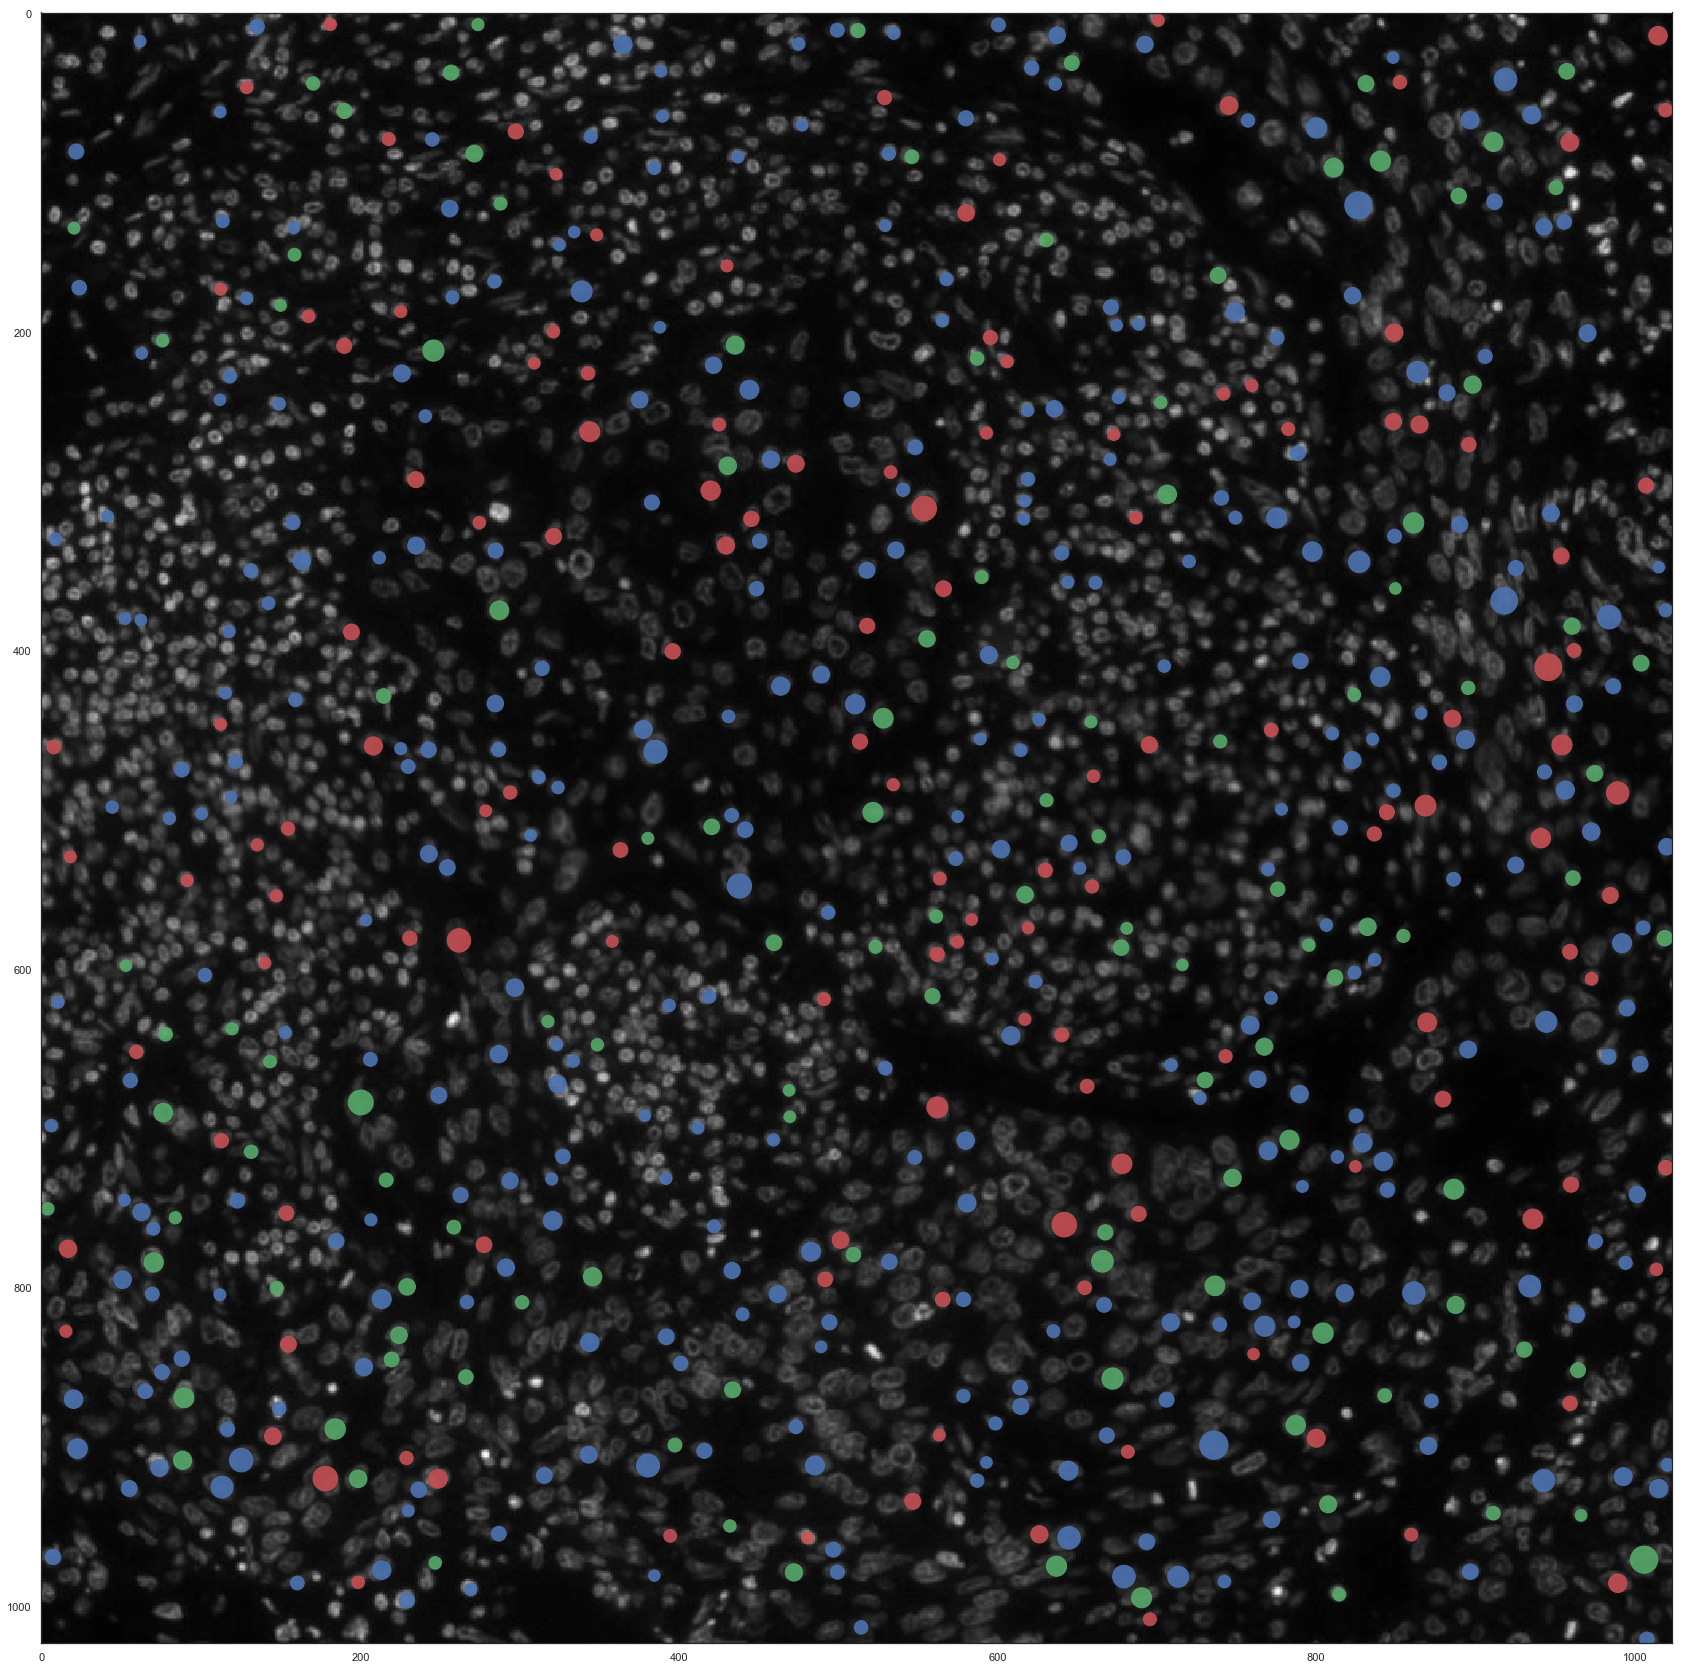

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
with open('/home/garner1/Work/dataset/cellImages/image52/properties3.csv', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
properties = np.array(properties) # with header

image = imageio.imread('/home/garner1/Work/dataset/cellImages/image52/iMS266_20190426_001.sub52.jpg')
sns.set(style='white', rc={'figure.figsize':(50,30)})

cmaps = ['b', 'r', 'g', 'y','c', 'k', 'w', 'm']

fig, ax = plt.subplots()
print set(labels)
for cluster in list(set(labels))[:-1]:
    clustered = (np.asarray(cluster_single_id)==cluster)
    cell_selection = np.asarray([d.keys()[ind] for ind in range(len(clustered)) if clustered[ind]])
    cluster_selection = np.asarray([d.values()[ind] for ind in range(len(clustered)) if clustered[ind]])
    if len(cell_selection) > 0:
        circle_size = np.sqrt(np.asarray(properties[cell_selection,1].astype(np.float))*1.0/6.2)
        circle_x = np.asarray(properties[cell_selection,2].astype(np.float))
        circle_y = np.asarray(properties[cell_selection,3].astype(np.float))
        for i in range(len(cell_selection)):
            c = plt.Circle((circle_x[i],circle_y[i]), circle_size[i],color=cmaps[cluster],alpha=0.9)
            ax.add_artist(c)

plt.imshow(image,cmap='gray')
plt.show()

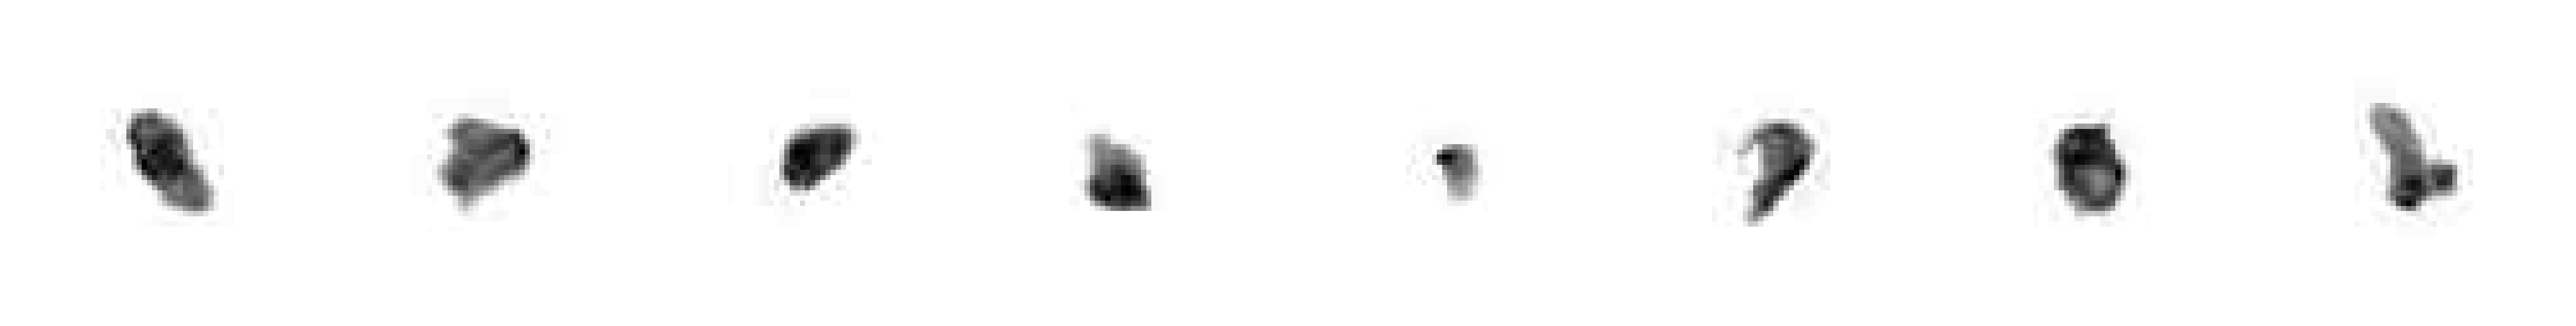

In [63]:
print(__doc__)

sns.set(style='white', context='notebook', rc={'figure.figsize':(80,60)})

num_of_examples = 8
rnd = random.sample([ind for ind in range(X_new.shape[0])],k=num_of_examples)
for index in range(num_of_examples):
    plt.subplot(1, num_of_examples, index + 1)
    plt.axis('off')
    plt.imshow(X_new[rnd[index]].reshape((Mwidths,Mheights)), cmap=plt.cm.gray_r, interpolation='nearest')
    
    
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.show()

In [131]:
# import csv
# with open('/home/garner1/Work/dataset/cellImages/image52/properties.csv', 'r') as f:
#     properties = list(csv.reader(f, delimiter=','))
# properties = np.array(properties) # with header

# fig = go.Figure()
# print list(set(labels))[:-1]
# for cluster in list(set(labels))[:-1]:
#     clustered = (np.asarray(cluster_single_id)==cluster)
#     cell_selection = np.asarray([d.keys()[ind] for ind in range(len(clustered)) if clustered[ind]])
#     cluster_selection = np.asarray([d.values()[ind] for ind in range(len(clustered)) if clustered[ind]])
#     if len(cell_selection) > 0:
#         fig.add_trace(go.Scatter(
#             x=properties[cell_selection,1].astype(np.float),  # <-- Put your data instead
#             y=properties[cell_selection,2].astype(np.float),  # <-- Put your data instead
#             name="cluster "+str(cluster),
#             mode="markers",
#             marker=dict(color=cluster,size=cluster+5, opacity=0.5)
#         ))
# fig.update_layout(title_text="Reduction in 3D ",title_font_size=30,template="plotly_white")

# fig.show()

[0, 1, 2]
